### Section 3: Data Modelling | Recommender system | Neural Nets

**Objective: **Imagine you have been tasked to build a recommendation system. Some training data is available at https://goo.gl/mHPsHM. The user-item ratings are in the form of {1, 2, 3, 4} s.t. 1=Hate, 2=Dislike, 3=Like, 4=Love. You have the option of treating this problem as either a regression- or multi-class classification-problem. The end goal is to develop a system which takes the user attributes as input and outputs the user-item rating.

#### Comments and results

In terms of model architecture the positbilities are endless. Nevertheless, I have seen small accuracy improvements by incrementing the model capacity, either in terms of number of factors in the users and items embedding layers, in previous MF implementation, or depth of the network in the current one.

That seems to tell that further accuracy improvements would probably be led by incrementing the training set, or by enhancing provided user profile data, either in number or quality of the features.

Best RMSE accuracy: 0.61

### Neural Net recommender system

In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
import random, math
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from torch.utils.data import DataLoader, Dataset

class UserItemInteractionsDataset(Dataset):
    def __init__(self, inters_sparse_matrix, mode):
        super().__init__()
        """
        'ix', 'ixs' and 'v' stand for index and value
        """
        self.inters = inters_sparse_matrix
        self.mode = mode
        
        # retrieve ratings indexes
        users_ixs, items_ixs = inters_sparse_matrix.nonzero()
        n_users, n_items, n_inters = len(np.unique(users_ixs)), len(np.unique(items_ixs)), len(users_ixs)

        self.data = {'users_ixs': users_ixs, 'items_ixs' : items_ixs}
    
        # shuffle and split data
        ss_ix = np.random.permutation(n_inters)
        ss_ixs = {'train': ss_ix[:len(ss_ix) * 3 // 5], 
                  'eval': ss_ix[len(ss_ix) * 3 // 5: len(ss_ix) * 4 // 5],
                  'test': ss_ix[len(ss_ix) * 4 // 5:]}
        
        self.dataset = {i: j[ss_ixs[mode]] for i, j in self.data.items()}
        self.dataset_size =  len(ss_ixs[mode])

        print('Setting "%s" dataset with %d users, %d items and %d interactions' %(mode, 
                                                                                len(np.unique(self.dataset['users_ixs'])),
                                                                                len(np.unique(self.dataset['items_ixs'])),
                                                                                len(ss_ixs[mode])))
        
    def __getitem__(self, index):
        
        user_ix, item_ix = self.dataset['users_ixs'][index], self.dataset['items_ixs'][index]
                
        user_ix_tensor = Variable(torch.LongTensor([user_ix]))
        item_ix_tensor = Variable(torch.LongTensor([item_ix]))
        inter_v_tensor = Variable(torch.FloatTensor([self.inters[user_ix, item_ix]]))        
        
        return user_ix_tensor, item_ix_tensor, inter_v_tensor

    def __len__(self):
        return self.dataset_size
    

# example:
# print(dataset_ev.__getitem__(0))
# if we want to retrieve the original id number: users_ids[user_ix]

def train_and_eval_model(dataloaders, model, optimizer, loss_fn, scheduler=None, epochs=10, verbose=True):

    modes = ['train', 'eval']
    losses = {i: [] for i in modes}
    
    print('\nTraining...')
    for e in range(epochs):
        for mode in modes:
            if mode == 'train': model.train()
            elif mode == 'eval': model.eval()
            else: print('WRONG!')

            per_batch_losses = []
            for _, batch in enumerate(dataloaders[mode]): 

                # index of the sparse matrix
                user_ix, item_ix, inter_v = batch

                # predict
                inter_v_pred = model(user_ix, item_ix)
                loss = loss_fn(inter_v_pred.view(inter_v.shape), inter_v)

                per_batch_losses.append(loss.item())

                # backpropagate & update weights
                if mode == 'train': 
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()

            epoch_loss = np.asarray(per_batch_losses).mean()
            losses[mode].append(epoch_loss)
            
            if verbose:
                if mode == 'train': print('epoch: %d | training loss: %.2f | ' %(e, epoch_loss), end='')
                else: print('validation loss: %.2f' %epoch_loss)
                
        if scheduler: scheduler.step()
                
    return losses

def eval_model(dataloaders, model, optimizer, loss_fn=torch.nn.MSELoss(), epochs=1):
    
    losses = []
    
    for e in range(epochs):
        for mode in ['test']:
            
            model.eval()
            
            per_batch_losses = []
            for _, batch in enumerate(dataloaders[mode]): 

                # index of the sparse matrix
                user_ix, item_ix, inter_v = batch

                # predict
                inter_v_pred = model(user_ix, item_ix)
                loss = loss_fn(inter_v_pred.view(inter_v.shape), inter_v)

                per_batch_losses.append(loss.item())

        epoch_loss = np.asarray(per_batch_losses).mean()
        losses.append(epoch_loss)
        
    print('\n *** test loss: MSE %.2f | RMSE %.2f ***\n' %(np.asarray(losses).mean(), math.sqrt(np.asarray(losses).mean())))
                
def predict_item(model, datasets, loss_fn=torch.nn.MSELoss()):

    eg = random.randint(0, len(datasets['test']))

    user_ix, item_ix, inter_v = (i.unsqueeze(0) for i in datasets['test'].__getitem__(eg))
    inter_v_pred = model(user_ix, item_ix)
    loss = loss_fn(inter_v_pred.view(inter_v.shape), inter_v)

    print('Example [test dataset] - Predicted rating: %.2f | Rating: %.2f | Loss: MSE %.4f RMSE: %.4f' 
          %(inter_v_pred, inter_v, loss, math.sqrt(loss)))

def load_data(load_upd=True, conf_file=None):

    # Loading ratings data

    ratings = pd.read_csv('../data/recommender/user_item_ratings.csv')
    ratings_pt = pd.pivot_table(ratings, index=['UserID'], columns=['ItemID'], fill_value=0, dropna=True)

    sparse_ratings = ratings_pt.values

    users_ids = np.unique(ratings['UserID'])
    items_ids = np.unique(ratings['ItemID'])
    n_users, n_items, n_atts = len(users_ids), len(items_ids), None

    if load_upd:
        
        # Loading user profiles data

        user_profiles = pd.read_csv('../data/recommender/user_attributes.csv', index_col=0).values
        n_users_profiles, n_atts = user_profiles.shape[0], user_profiles.shape[1]
        assert n_users == n_users_profiles

    print('Interaction matrix of %d users and %d items | Num. of interactions: %d | Num. of attributes per user: %s\n' 
          %(n_users, n_items, len(sparse_ratings.nonzero()[0]), str(n_atts)), end='')
    
    if not conf_file: conf_file = {}
    conf_file['n_users'] = n_users
    conf_file['n_items'] = n_items
    conf_file['n_factors'] = n_atts
    
    return sparse_ratings, user_profiles if load_upd else None, conf_file

In [3]:
class UserItemNNet(torch.nn.Module):
    
    def __init__(self, config_file, user_profiles=None, p_drop=0.):
        super().__init__()
        
        n_users, n_items, n_factors = (config_file[i] for i in ['n_users', 'n_items', 'n_factors'])

        self.user_factors = torch.nn.Embedding(n_users, n_factors) #, sparse=True)
        self.item_factors = torch.nn.Embedding(n_items, n_factors) #, sparse=True)
        self.user_biases = torch.nn.Embedding(n_users, 1) #, sparse=True)
        self.item_biases = torch.nn.Embedding(n_items, 1) #, sparse=True)
        
        exp_depth = config_file['expansion_depth']
        self.fc_layers = [n_factors * 2]
        [self.fc_layers.append(self.fc_layers[-1] * 2) for i in range(exp_depth)]
        [self.fc_layers.append(self.fc_layers[-1] // 2) for i in range(exp_depth)]
        
        self.fc_module = torch.nn.ModuleList()
        for _, (in_size, out_size) in enumerate(zip(self.fc_layers[:-1], self.fc_layers[1:])):
            self.fc_module.append(torch.nn.Linear(in_size, out_size))
        
        # either
        self.fc_module.append(torch.nn.Linear(self.fc_layers[-1], 1))
        # or
#         self.fc_out = torch.nn.Linear(torch.nn.Linear(self.fc_layers[-1], 1))
        
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(p=p_drop)
            
        self.user_profiles = user_profiles
        if user_profiles is not None: 
            assert n_factors == user_profiles.shape[1]
            n_factors = user_profiles.shape[1]
      
    def forward(self, user, item, max_v=4., min_v=1.):
        "MF-like bit:"
        'users & items embedding matrices'
        if self.user_profiles is not None: 
            user_profiles = torch.FloatTensor(self.user_profiles)
            ufs = user_profiles[user] * torch.nn.ReLU()((self.user_factors(user)))
        else: 
            ufs = self.dropout(torch.nn.ReLU()((self.user_factors(user))))
#         ufs += self.user_biases(user).view(ufs.shape)
        ifs = self.dropout(torch.nn.ReLU()((self.item_factors(item))))
#         ifs += self.item_biases(item).view(ifs.shape)
#         pred = (ufs * ifs).sum(-1)
#         pred += (self.user_biases(user) + self.item_biases(item)).view(pred.shape)
        
        "NN-like bit:"
        if self.user_profiles is not None: 
            ups = torch.FloatTensor(self.user_profiles)[user]
        out = torch.cat([ufs, ifs], dim=-1)  # concat. the output of the MF bit
        for linear_layer in self.fc_module:
#             print(out.shape)
            out = torch.nn.BatchNorm1d(1)(out)
            out = torch.nn.ReLU()(out)
            out = linear_layer(out)
            # out = self.dropout(out)
#         print(out.shape)
        out = self.sigmoid(out) * (max_v - min_v) + min_v
        return out

Interaction matrix of 1912 users and 805 items | Num. of interactions: 29464 | Num. of attributes per user: 50
Setting "train" dataset with 1840 users, 805 items and 17678 interactions
Setting "eval" dataset with 1612 users, 802 items and 5893 interactions
Setting "test" dataset with 1621 users, 801 items and 5893 interactions
UserItemNNet(
  (user_factors): Embedding(1912, 50)
  (item_factors): Embedding(805, 50)
  (user_biases): Embedding(1912, 1)
  (item_biases): Embedding(805, 1)
  (fc_module): ModuleList(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): Linear(in_features=100, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.0)
)

Training...

 *** test loss: MSE 0.45 | RMSE 0.67 ***

Example [test dataset] - Predicted rating: 3.76 | Rating: 3.00 

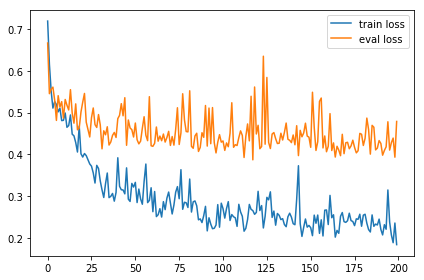

In [43]:
conf_file = {
              'expansion_depth': 2, # depth of the NN // 2 
              'l2_regularization': 1e-7, 
              'model_dir':'checkpoints/{}_Epoch_{}_bs_{}_lr_{:.4f}_RMSE_{:.4f}.model'
}

def main(conf_file):
    epochs = 200
    modes = ['train', 'eval', 'test']
    
    sparse_ratings, user_profiles, conf_file = load_data(conf_file=conf_file)
    
    datasets = {i: UserItemInteractionsDataset(sparse_ratings, i) for i in modes}
    dataloaders = {i: DataLoader(datasets[i], batch_size=512, shuffle=True, num_workers=0) for i in modes}

    loss_fn = torch.nn.MSELoss() 
    model = UserItemNNet(conf_file, user_profiles=user_profiles, p_drop=0.); print(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100)
#     torch.optim.SGD(model.parameters(), lr=1e-1)
    
    losses = train_and_eval_model(dataloaders, model, optimizer, loss_fn, scheduler=None, epochs=epochs, verbose=False)
    eval_model(dataloaders, model, optimizer)
    
    plt.plot(losses['train'])
    plt.plot(losses['eval'])
    plt.tight_layout() 
    plt.legend(['train loss', 'eval loss'])
    
    predict_item(model, datasets)
    
main(conf_file)